In [84]:
from datetime import datetime
from alpha_realtime_stock import AlphaRealtimeStock
import time
import timeit
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler

from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense, Dropout   ## importing layers of Neural network
from keras.callbacks import ModelCheckpoint     ## imporing modelcheck pointer
from keras.losses import MSE                  ## importing error function
from keras.optimizers import Adam              ## importing optimizer
from keras.activations import relu


def get_crumbs():
    """
    get crumb  from yahoo finance
    returns crumb
    """
    url = 'https://finance.yahoo.com/quote'
    header = {'Connection': 'keep-alive',
              'Expires': '-1',
              'Upgrade-Insecure-Requests': '1',
              'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_4) \
               AppleWebKit/537.36 (KHTML, like Gecko) Chrome/81.0.4044.138 Safari/537.36'
              }

    website = requests.get(url, headers=header)
    soup = BeautifulSoup(website.text, 'lxml')
    crumb = re.findall('"CrumbStore":{"crumb":"(.+?)"}', str(soup))
    return crumb[0]

crumb = get_crumbs()
ticker_list = ['ZM']
stock_collection = {}
for ticker in ticker_list:
    stock = AlphaRealtimeStock(ticker, crumb)
    stock_collection[ticker] = stock
# while True:
#     print(datetime.now().strftime("%H:%M:%S"))
    for ticker in ticker_list:
        stock = stock_collection[ticker]
        stock.fetch_webdata()
#         df = stock.get_Stoch_RSI_Indicator()
#         print(df.tail())
#     end = timeit.default_timer()
#     time.sleep(5)

In [85]:
data_tsla = stock.fetch_webdata()

In [86]:
data_tsla.tail()

,Datetime,Open,High,Low,Close,Volume
458,2020-09-23 09:40:00,521.465027,521.820007,518.849976,519.635010,194566
459,2020-09-23 09:45:00,519.210022,524.244995,517.564392,523.690002,306407
460,2020-09-23 09:50:00,523.869995,523.880005,520.310120,523.116028,241351
461,2020-09-23 09:55:00,522.789978,523.679993,521.750000,522.010071,78456
462,2020-09-23 09:57:49,522.719971,522.719971,522.719971,522.719971,0


In [87]:
df = data_tsla.copy()

In [88]:
#df.to_csv('INO.csv')

In [89]:
df = df.dropna()

In [90]:
df.shape[0]


463

In [91]:
df['Open']

0      418.500000
1      419.839996
2      419.510010
3      420.700012
4      418.719910
          ...    
458    521.465027
459    519.210022
460    523.869995
461    522.789978
462    522.719971
Name: Open, Length: 463, dtype: float64

In [92]:
df['mid_day'] =  (df['Open'] + df['Close'])/2

In [93]:
df['mid_day'].median()

467.91

In [94]:
window = 21
no_of_std = 2
#Calculate rolling mean and standard deviation using number of days set above
rolling_mean = df['Open'].rolling(window).mean()
rolling_std = df['Open'].rolling(window).std()
#create two new DataFrame columns to hold values of upper and lower Bollinger bands
df['Rolling Mean'] = rolling_mean
df['Bollinger High'] = rolling_mean + (rolling_std * no_of_std)
df['Bollinger Low'] = rolling_mean - (rolling_std * no_of_std)

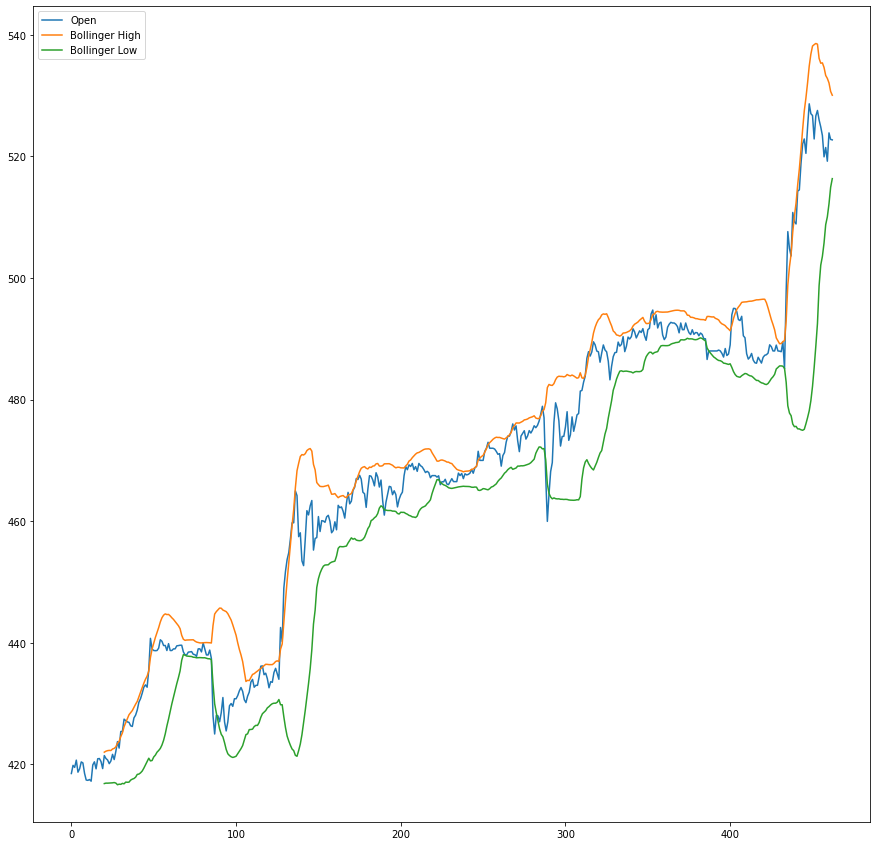

In [95]:
df[['Open','Bollinger High','Bollinger Low']].plot(figsize=(15,15));


In [83]:
# First calculate the mid prices from the highest and lowest
high_prices = df.loc[:,'High'].to_numpy()
low_prices = df.loc[:,'Low'].to_numpy()
mid_prices = (high_prices+low_prices)/2.0

In [73]:
# number of traing data
n = int(df.shape[0]*0.8)


In [45]:
train_data = mid_prices[:n]
test_data = mid_prices[n:]

In [46]:
# Scale the data to be between 0 and 1
# When scaling remember! You normalize both test and train data with respect to training data
# Because you are not supposed to have access to test data
scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)
test_data = test_data.reshape(-1,1)

In [47]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaler = scaler.fit(train_data)

In [48]:
train_data = scaler.transform(train_data)

In [49]:
test_data = scaler.transform(test_data)

In [50]:
EMA = 0.0
gamma = 0.1
for ti in range(n):
  EMA = gamma*train_data[ti] + (1-gamma)*EMA
  train_data[ti] = EMA

# Used for visualization and test purposes
all_mid_data = np.concatenate([train_data,test_data],axis=0)

In [51]:
test_data.shape

(52, 1)

In [53]:
window_size = 10
N = train_data.size
std_avg_predictions = []
std_avg_x = []
mse_errors = []

for pred_idx in range(window_size,N):

    if pred_idx >= N:
        date = dt.datetime.strptime(k, '%Y-%m-%d').date() + dt.timedelta(days=1)
    else:
        date = df.loc[pred_idx,'Datetime']

    std_avg_predictions.append(np.mean(train_data[pred_idx-window_size:pred_idx]))
    mse_errors.append((std_avg_predictions[-1]-train_data[pred_idx])**2)
    std_avg_x.append(date)

print('MSE error for standard averaging: %.5f'%(0.5*np.mean(mse_errors)))

KeyError: 15

In [28]:
all_mid_data.shape

(256, 1)

ValueError: x and y must have same first dimension, but have shapes (104,) and (20,)

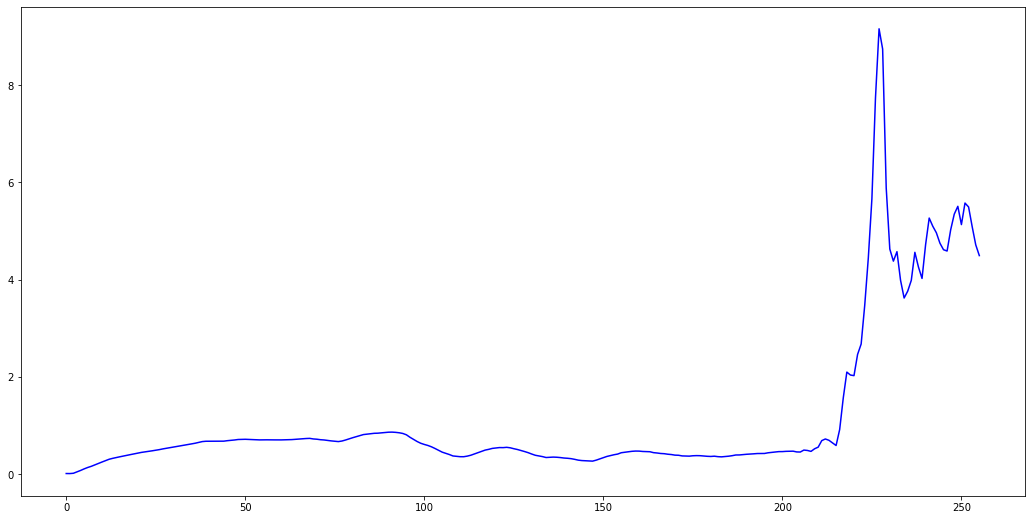

In [29]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(window_size,N),std_avg_predictions,color='orange',label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [88]:
window_size = 10
N = train_data.size

run_avg_predictions = []
run_avg_x = []

mse_errors = []

running_mean = 0.0
run_avg_predictions.append(running_mean)

decay = 0.5

for pred_idx in range(1,N):

    running_mean = running_mean*decay + (1.0-decay)*train_data[pred_idx-1]
    run_avg_predictions.append(running_mean)
    mse_errors.append((run_avg_predictions[-1]-train_data[pred_idx])**2)
    run_avg_x.append(date)

print('MSE error for EMA averaging: %.5f'%(0.5*np.mean(mse_errors)))

MSE error for EMA averaging: 0.00004


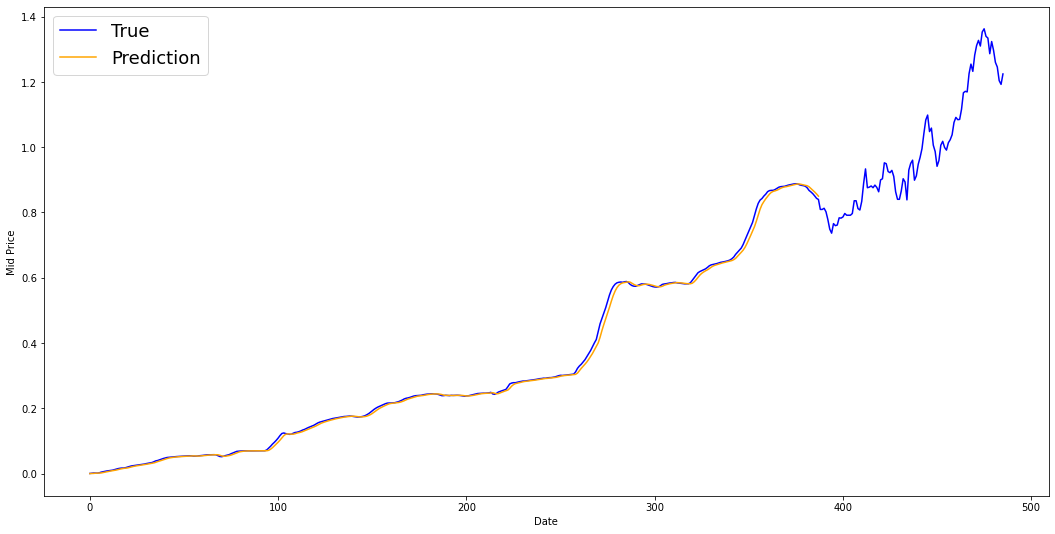

In [89]:
plt.figure(figsize = (18,9))
plt.plot(range(df.shape[0]),all_mid_data,color='b',label='True')
plt.plot(range(0,N),run_avg_predictions,color='orange', label='Prediction')
#plt.xticks(range(0,df.shape[0],50),df['Date'].loc[::50],rotation=45)
plt.xlabel('Date')
plt.ylabel('Mid Price')
plt.legend(fontsize=18)
plt.show()

In [90]:
###  exponential smoothing

<Figure size 432x288 with 0 Axes>

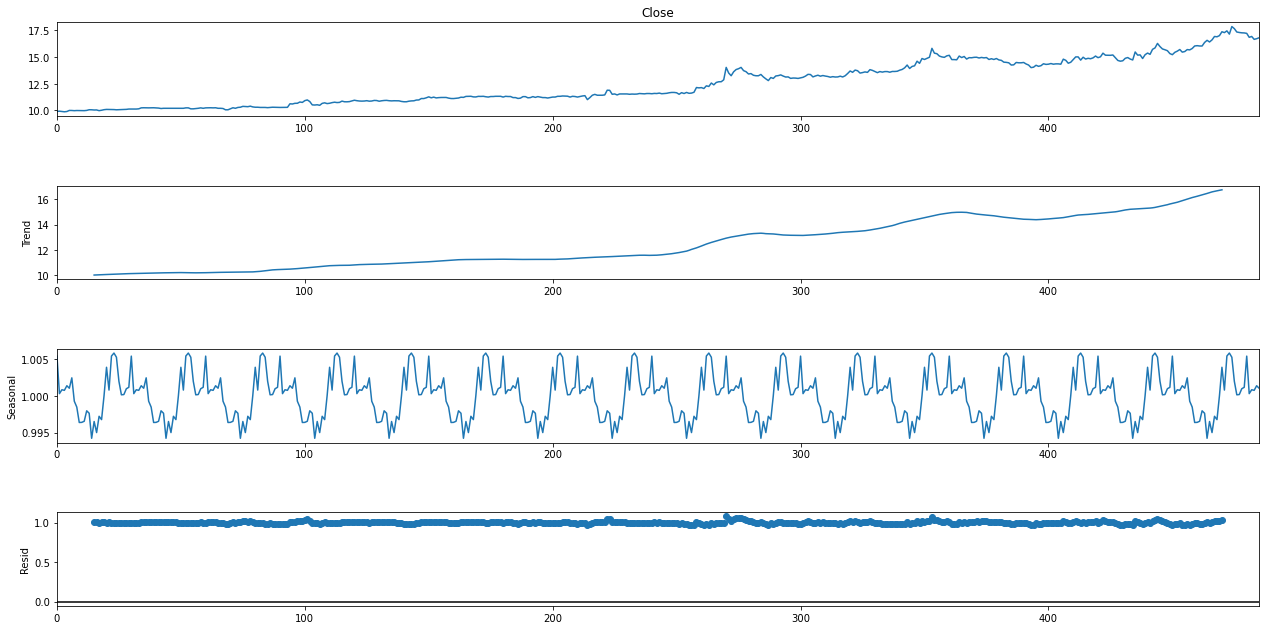

In [91]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Checking decomposition of trend, seasonality and residue of the original time seires.
decomposition = seasonal_decompose(data_tsla['Close'], model='multiplicative', period=30)
fig = plt.figure()  
fig = decomposition.plot()  
fig.set_size_inches(20, 10)

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: 0.236698
p-value: 0.974246
Critical Values:
	1%: -3.444
	5%: -2.868
	10%: -2.570
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 2.541840
p-value: 0.010000
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


/Users/mosal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/Users/mosal/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


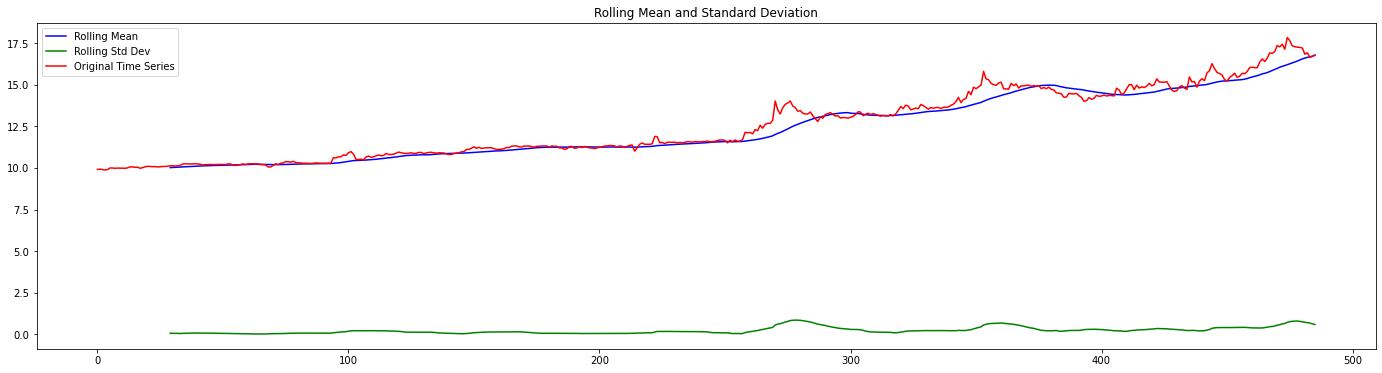

In [92]:

#Testing for stationarity using ADF and KPSS Tests.
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss
def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, color='blue', label='Rolling Mean')
    plt.plot(rolling_std_dev, color='green', label = 'Rolling Std Dev')
    plt.plot(stock_close_price, color='red',label='Original Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags=None, store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
        
stationarity_test(data_tsla['Close'])

ADF Test:
Null Hypothesis: Not Stationary
ADF Statistic: -4.313214
p-value: 0.000421
Critical Values:
	1%: -3.445
	5%: -2.868
	10%: -2.570
KPSS Test:
Null Hypothesis: Stationary
KPSS Statistic: 0.372578
p-value: 0.088975
Critical Values:
	10%: 0.347
	5%: 0.463
	2.5%: 0.574
	1%: 0.739


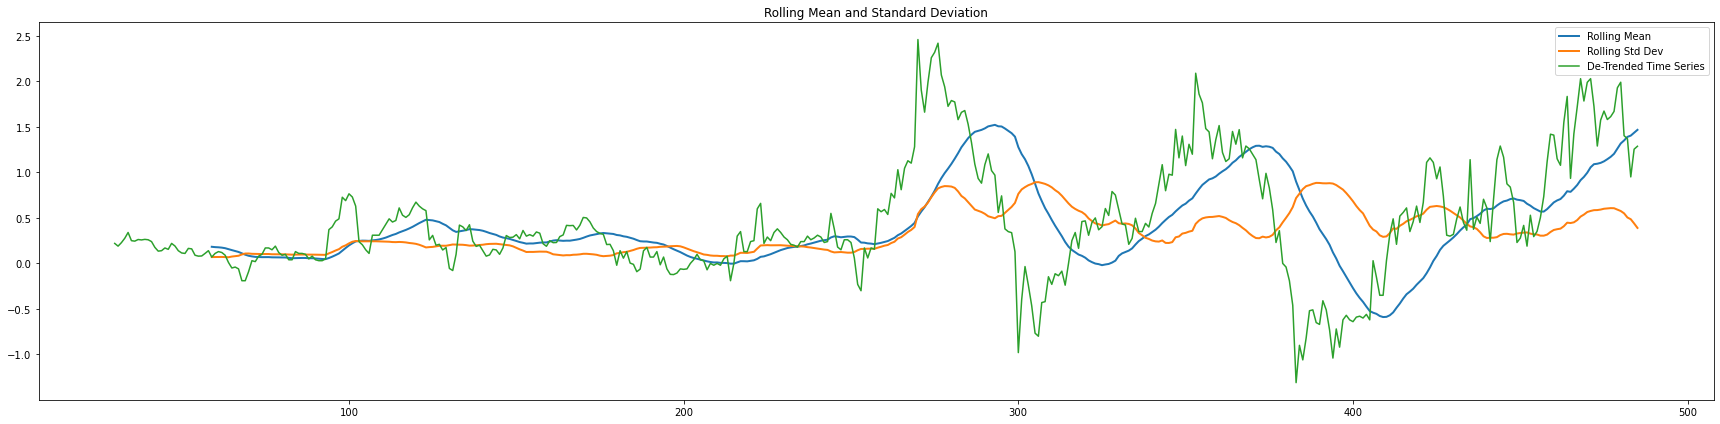

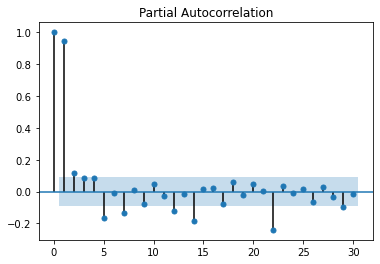

In [93]:
#Testing for stationarity of de-trended time series using ADF and KPSS Tests.

# De-trending the time series
data_tsla['Close_Detrend'] = (data_tsla['Close'] - data_tsla['Close'].shift(30))

def stationarity_test(stock_close_price):
    # Calculating rolling mean and rolling standard deviation:
    rolling_mean = stock_close_price.rolling(30).mean()
    rolling_std_dev = stock_close_price.rolling(30).std()
  
    # Plotting the statistics:
    plt.figure(figsize=(24,6))
    plt.plot(rolling_mean, label='Rolling Mean',linewidth=2.0)
    plt.plot(rolling_std_dev, label = 'Rolling Std Dev',linewidth=2.0)
    plt.plot(stock_close_price,label='De-Trended Time Series')
    plt.legend(loc='best')
    plt.title('Rolling Mean and Standard Deviation')
    plt.tight_layout()
    
    print("ADF Test:")
    adf_test = adfuller(stock_close_price,autolag='AIC')
    print('Null Hypothesis: Not Stationary')
    print('ADF Statistic: %f' % adf_test[0])
    print('p-value: %f' % adf_test[1])
    print('Critical Values:')
    for key, value in adf_test[4].items():
        print('\t%s: %.3f' % (key, value))

    print("KPSS Test:")
    kpss_test = kpss(stock_close_price, regression='c', nlags=None, store=False)
    print('Null Hypothesis: Stationary')
    print('KPSS Statistic: %f' % kpss_test[0])
    print('p-value: %f' % kpss_test[1])
    print('Critical Values:')
    for key, value in kpss_test[3].items():
        print('\t%s: %.3f' % (key, value))
    
stationarity_test(data_tsla['Close_Detrend'].dropna())

# PACF Plot
from statsmodels.graphics.tsaplots import plot_pacf
pacf = plot_pacf(data_tsla['Close_Detrend'].dropna(), lags=30)

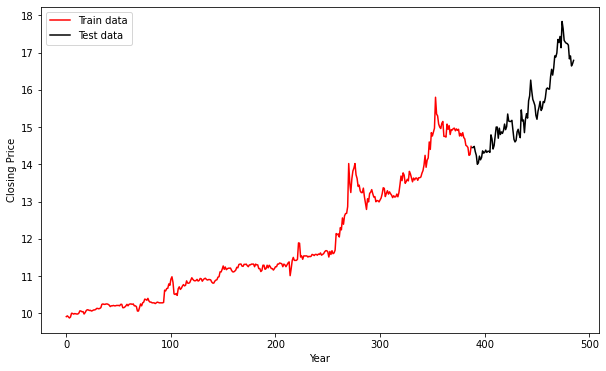

In [94]:
#split data into train and training set
Stock_data_arima = data_tsla['Close']
train_test_split_ratio = int(len(Stock_data_arima)*0.8)
train_data, test_data = Stock_data_arima[:train_test_split_ratio], Stock_data_arima[train_test_split_ratio:]


# Plotting the train and test sets.
plt.figure(figsize=(10,6))
plt.xlabel('Year')
plt.ylabel('Closing Price')
plt.plot(train_data, 'red', label='Train data')
plt.plot(test_data, 'black', label='Test data')
plt.legend();

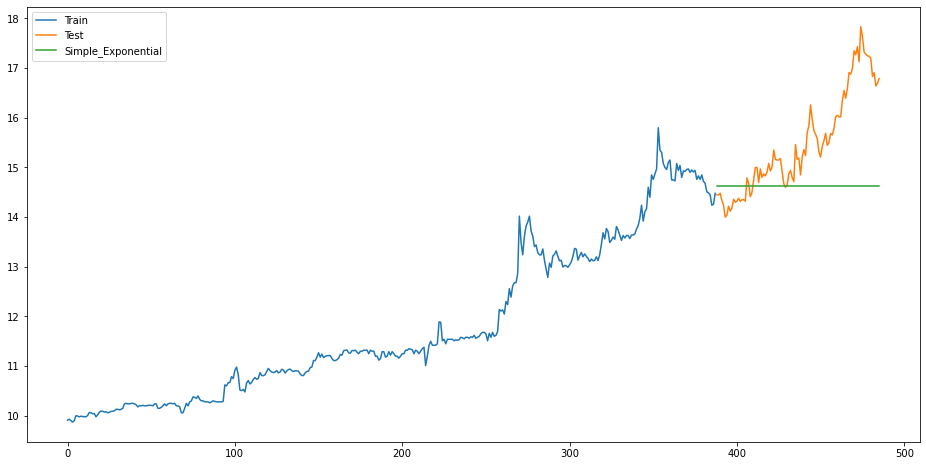

Simple Exponential Smoothing RMS :- 1.316 & Smoothing Level :- 0.1


In [100]:
# Simple Exponential Smoothing Method
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.api import ExponentialSmoothing,SimpleExpSmoothing
pred_values = test_data.copy()
pred_values = pd.DataFrame(pred_values)

Simple_Exponential_df = pd.DataFrame(columns = ['RMS','Smoothing Level'])

from itertools import permutations
perm = permutations(list(np.linspace(0.05,1,num=20)), 1)
for i in list(perm):
  fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = i[0])
  pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

  rms = round(sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential)),3)
  Simple_Exponential_df = Simple_Exponential_df.append(other = {'RMS' : rms , 'Smoothing Level' : i[0]} , ignore_index=True)

opt_values = Simple_Exponential_df.loc[Simple_Exponential_df['RMS'] == min(Simple_Exponential_df['RMS']),['Smoothing Level']].values


# Using optimised values from the lists.
fit_sim_exp = SimpleExpSmoothing(np.asarray(train_data)).fit(smoothing_level = opt_values[0][0])
pred_values['Simple_Exponential'] = fit_sim_exp.forecast(len(test_data))

plt.figure(figsize=(16,8))
plt.plot(train_data, label='Train')
plt.plot(test_data, label='Test')
plt.plot(pred_values['Simple_Exponential'], label='Simple_Exponential')
plt.legend(loc='best')
plt.show()

rms_sim_exp = sqrt(mean_squared_error(test_data.values, pred_values.Simple_Exponential))
print("Simple Exponential Smoothing RMS :- " + str(round(rms_sim_exp,3)) + " & Smoothing Level :- "+str(round(opt_values[0][0],3)))